# 1. Prétraitement et visualition des données

In [27]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

#Fonction qui affiche le string en markdown
def printmd(string):
    display(Markdown(string))

In [2]:
# Créé la liste des chemins pour le train et le test
dir_ = Path('../input/lego-brick-images/dataset')
file_paths = list(dir_.glob(r'**/*.png'))
file_paths = [str(x) for x in file_paths]
df = pd.DataFrame({'Filepath':file_paths})

In [3]:
def get_label(string):
    string  = ' '.join(string.split('/')[-1].replace('.png', '').split(' ')[1:-1])
    string = string.lower()
    return string

# Récupère le label à partir du chemin
df['Label'] = df['Filepath'].apply(lambda x: get_label(x))

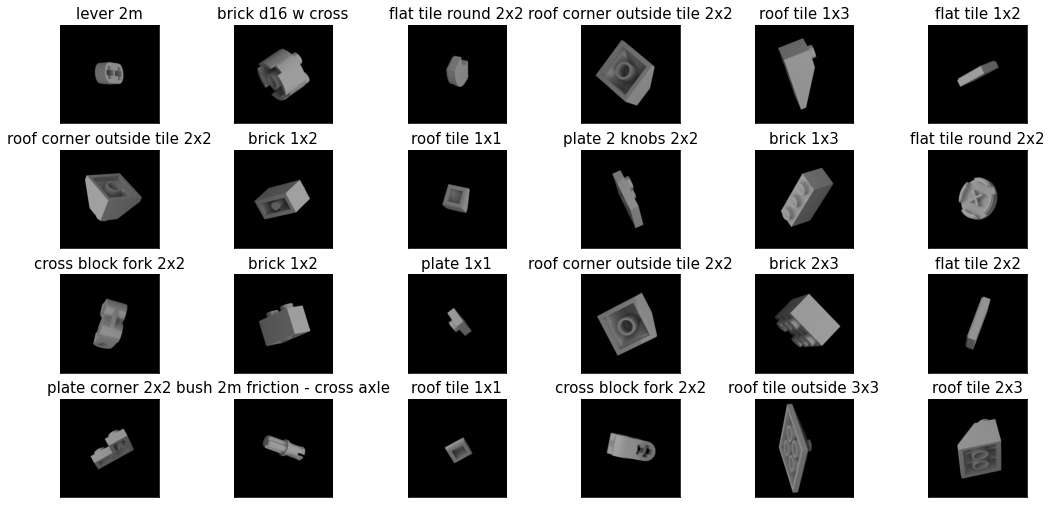

In [4]:
# Affiche certaines images du dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

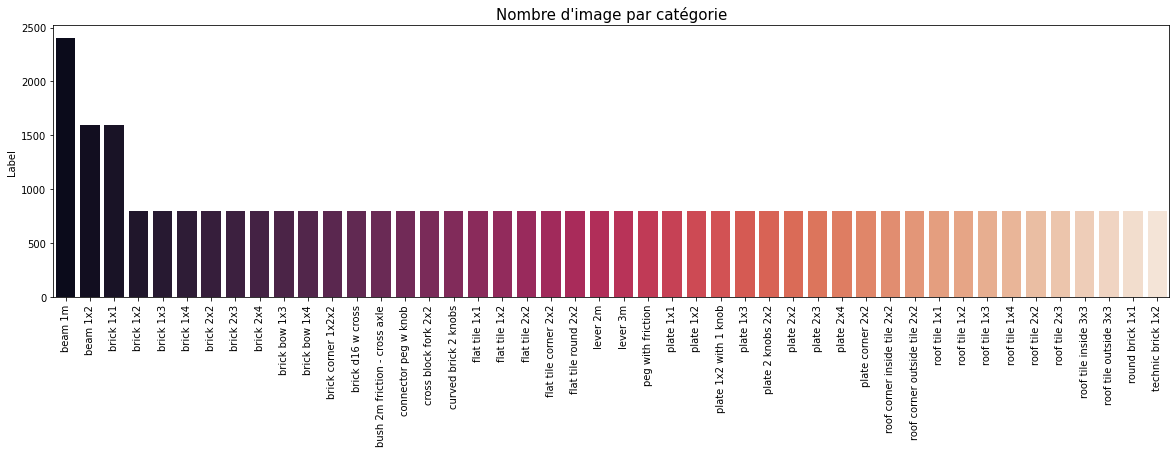

In [28]:
# Affiche le nombre d'image par catégorie
vc = df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Nombre d'image par catégorie", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

In [6]:
# Charge les chemins des images de validation
validation = pd.read_csv('../input/lego-brick-images/validation.txt', names = ['Filepath'])
validation['Filepath'] = validation['Filepath'].apply(lambda x: '../input/lego-brick-images/dataset/' + x)
validation.head()

,Filepath
0,../input/lego-brick-images/dataset/14719 flat ...
1,../input/lego-brick-images/dataset/14719 flat ...
2,../input/lego-brick-images/dataset/14719 flat ...
3,../input/lego-brick-images/dataset/14719 flat ...
4,../input/lego-brick-images/dataset/14719 flat ...


In [7]:
df['validation_set'] = df['Filepath'].isin(validation['Filepath'])
df.head()

,Filepath,Label,validation_set
0,../input/lego-brick-images/dataset/41677 lever...,lever 2m,False
1,../input/lego-brick-images/dataset/6143 Brick ...,brick d16 w cross,False
2,../input/lego-brick-images/dataset/27925 flat ...,flat tile round 2x2,False
3,../input/lego-brick-images/dataset/3045 roof c...,roof corner outside tile 2x2,False
4,../input/lego-brick-images/dataset/4286 roof t...,roof tile 1x3,False


In [8]:
train_df = df[df['validation_set'] == False].sample(frac = 0.3)
test_df = df[df['validation_set'] == True].sample(frac = 0.3)

In [29]:
a = 0
printmd(f'### Nombre d\'image dans le train: {train_df.shape[0]}')
printmd(f'### Nombre d\'image dans le test: {test_df.shape[0]}')

### Nombre d'image dans le train: 32000

### Nombre d'image dans le test: 8000

# 2. Charger les images à l'aide d'un générateur et d'une augmentation de données

In [10]:
def create_gen():
    # Charge les images avec un générateur et une augmentation de données
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

# 3. Test de 20 modèles pré-entrainés

In [11]:
def get_model(model):
# Charge le modèle pré-entraîné
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(46, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [12]:
# Liste de tous les modèles
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

# Création du générateur
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Pour chaque modèle de la liste
for name, model in models.items():
    
    # Récupération du modèle
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Entraînement du modèle
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)
    
    # Sauvegarde la durée et la val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 8640 validated image filenames belonging to 46 classes.
Found 960 validated image filenames belonging to 46 classes.
Found 2400 validated image filenames belonging to 46 classes.


270/270 [==============================] - 77s 251ms/step - loss: 2.7383 - accuracy: 0.2688 - val_loss: 1.2366 - val_accuracy: 0.5885
DenseNet121          trained in 77.85 sec
270/270 [==============================] - 41s 140ms/step - loss: 2.6845 - accuracy: 0.2780 - val_loss: 1.2174 - val_accuracy: 0.6000
MobileNetV2          trained in 40.79 sec
270/270 [==============================] - 49s 150ms/step - loss: 2.7400 - accuracy: 0.2736 - val_loss: 1.0580 - val_accuracy: 0.6417
DenseNet169          trained in 49.16 sec
270/270 [==============================] - 52s 155ms/step - loss: 2.6855 - accuracy: 0.2736 - val_loss: 1.1721 - val_accuracy: 0.6000
DenseNet201          trained in 52.2 sec
270/270 [==============================] - 54s 164ms/step - loss: 2.8692 - accuracy: 0.2323 - val_loss: 1.6762

In [13]:
# Créé une DF avec les résultats
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_accuracy,Training time (sec)
0,DenseNet169,0.6417,49.16
1,MobileNet,0.6146,41.28
2,ResNet152V2,0.6094,50.92
3,ResNet50V2,0.6073,42.70
4,MobileNetV2,0.6000,40.79
5,DenseNet201,0.6000,52.20
6,ResNet101V2,0.5958,46.83
7,DenseNet121,0.5885,77.85
8,Xception,0.5177,44.40
9,InceptionV3,0.4896,45.25


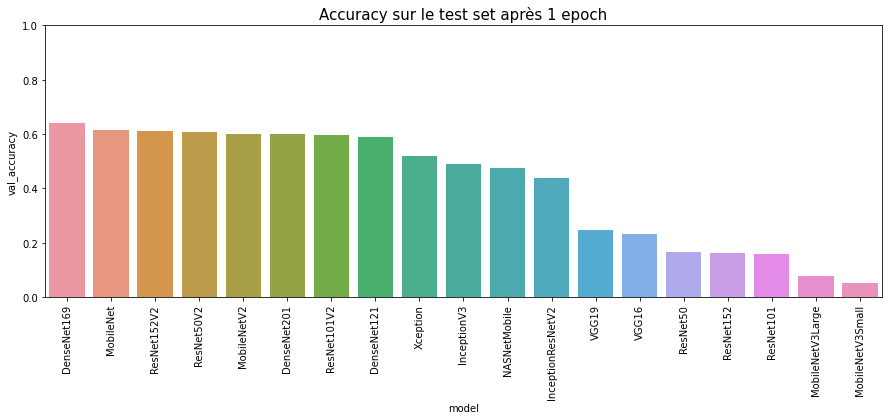

In [31]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results)
plt.title('Accuracy sur le test set après 1 epoch', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

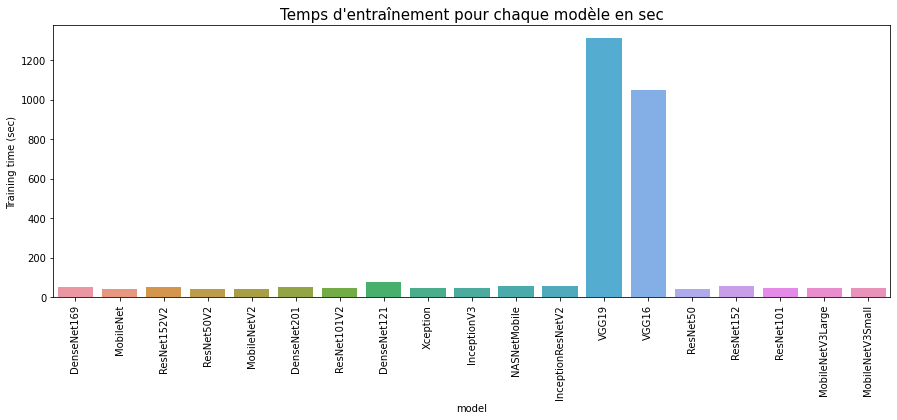

In [33]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Temps d\'entraînement pour chaque modèle en sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

# 4. Entraînement de l'IA à partir du meilleur modèle

In [34]:
train_df = df[df['validation_set'] == False]
test_df = df[df['validation_set'] == True]

# Création du générateur
train_generator,test_generator,train_images,val_images,test_images=create_gen()

# Récupération du meilleur modèle
best_model = df_results.iloc[0]

# Création du nouveau modèle
model = get_model( eval("tf.keras.applications."+ best_model[0]) )

# Entraînement du nouveau modèle
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=20,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=3,
                            restore_best_weights=True)]
                    )

Found 28800 validated image filenames belonging to 46 classes.
Found 3200 validated image filenames belonging to 46 classes.
Found 8000 validated image filenames belonging to 46 classes.
Epoch 1/20
900/900 [==============================] - 136s 143ms/step - loss: 1.8344 - accuracy: 0.4729 - val_loss: 0.7192 - val_accuracy: 0.7422
Epoch 2/20
900/900 [==============================] - 126s 140ms/step - loss: 0.6260 - accuracy: 0.7863 - val_loss: 0.5883 - val_accuracy: 0.7850
Epoch 3/20
900/900 [==============================] - 127s 141ms/step - loss: 0.4785 - accuracy: 0.8326 - val_loss: 0.5339 - val_accuracy: 0.8072
Epoch 4/20
900/900 [==============================] - 127s 141ms/step - loss: 0.4131 - accuracy: 0.8529 - val_loss: 0.5352 - val_accuracy: 0.8031
Epoch 5/20
900/900 [==============================] - 127s 141ms/step - loss: 0.3651 - accuracy: 0.8654 - val_loss: 0.5081 - val_accuracy: 0.8206
Epoch 6/20
900/900 [==============================] - 128s 142ms/step - loss: 0.336

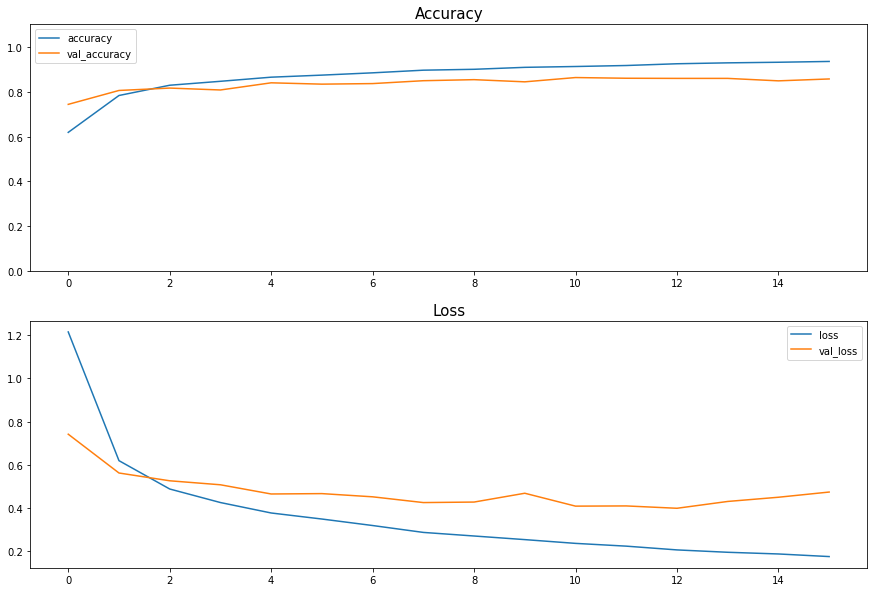

In [17]:
#Affichage de la courbe de loss et d'accuracy
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

In [35]:
# Prédiction du label sur le test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Rapproche les labels
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Récupère l'accurary sur le test set
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)

# Affiche le résultat
printmd(f'## Meilleur modèle: {best_model[0]} avec {acc*100:.2f}% d\'accuracy sur le test set')

## Meilleur modèle: DenseNet169 avec 87.09% d'accuracy sur le test set

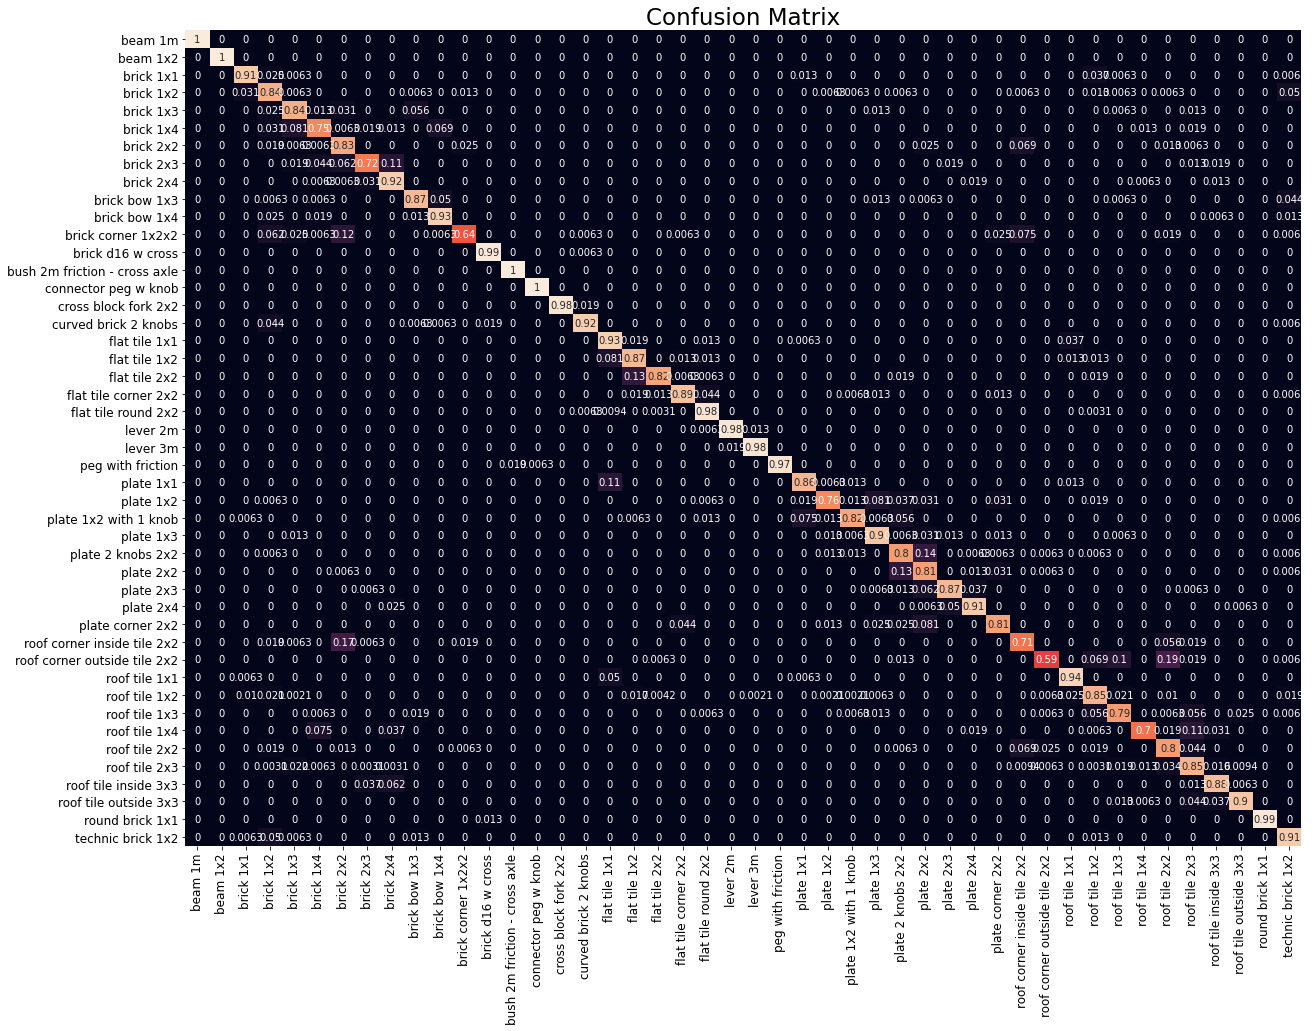

In [36]:
# Affichage de la matrice de confusion
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12,rotation=90)
plt.yticks(fontsize=12)
plt.show()

# 5. Exemple de prédictions


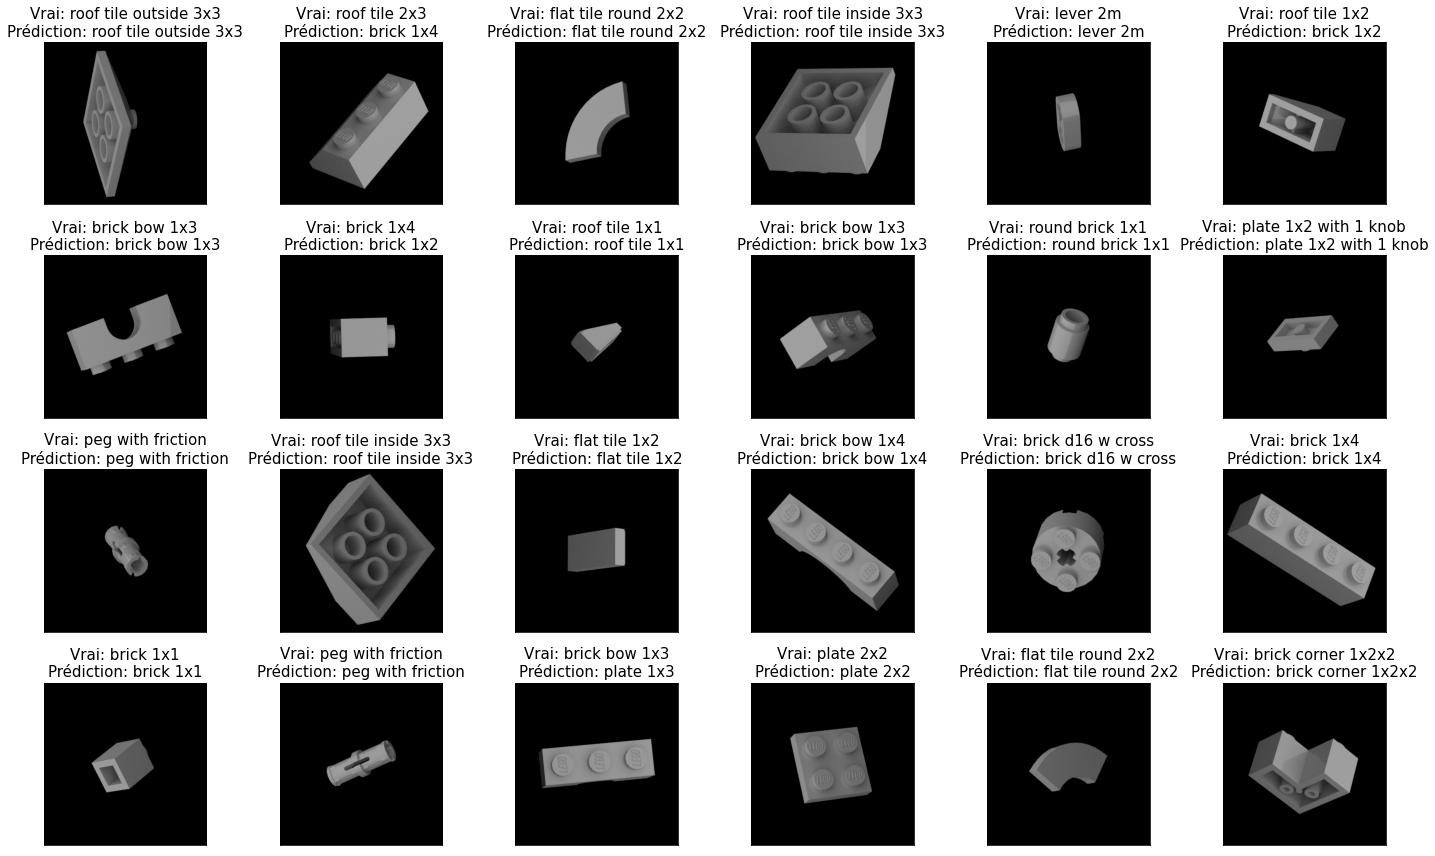

In [37]:
# Affiche des images du dataset avec leurs labels et la prédiction
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"Vrai: {test_df.Label.iloc[i].split('_')[0]}\nPrédiction: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

In [21]:
model.save("predictLego.h5")

## Test avec images issues de la première IA

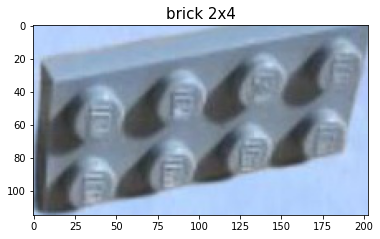

In [25]:
model = tf.keras.models.load_model("predictLego.h5")

# Chargement de l'image
img = tf.keras.preprocessing.image.load_img("/kaggle/input/test-lego/crop_3_f180a552-f731-4336-8409-5faf4ffde5aa.jpg", target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

# Prédiction du label
pred = model.predict(img)
pred = np.argmax(pred,axis=1)

# Rapprochement du label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())

# Affichage du résultat
plt.imshow(plt.imread("/kaggle/input/test-lego/crop_3_f180a552-f731-4336-8409-5faf4ffde5aa.jpg"))
plt.title(labels[pred[0]], fontsize = 15)
plt.show()